In [1]:
import torch
import numpy as np
import auction
import torch.nn as nn
import torch.nn.functional as F
import timeit
import sinkhorn
import matplotlib.pyplot as plt

In [36]:
lambrange = np.concatenate((np.linspace(0.0005, 1, 20), np.geomspace(0.0005, 1, 20)))
lambrange = np.sort(lambrange[1:-1])
niter_sink = 1000 # require a large niter_sink for small values of lamb
niter = 1000
lr = 0.01
batch = 1000
size_layer = 100
K = 10
nactions = 2+K
y = torch.linspace(1./K, 1., K) # discretization of uniform distribution
beta= torch.ones(K)/K
nexp = 10
err_threshold = 1e-3
device = "cpu"
startexp = 1

In [17]:
utility = []
privacy_losses = []
losses = []
for lamb in lambrange:
    us = 0
    ps = 0
    s = 0
    for exp in range(startexp, nexp+startexp):
        us+=np.load('experiments/sinkhorn_auction/{0}_lamb{1}_k{2}_sinkiter{3}_lr{4}_sinkhorn_{5}_batch{6}/eval_utility_loss.npy'.format(exp,lamb,y.size(0), 
                  niter_sink, lr, device, batch))
        ps+=np.load('experiments/sinkhorn_auction/{0}_lamb{1}_k{2}_sinkiter{3}_lr{4}_sinkhorn_{5}_batch{6}/eval_privacy_loss.npy'.format(exp,lamb,y.size(0), 
                  niter_sink, lr, device, batch))
        s+=np.load('experiments/sinkhorn_auction/{0}_lamb{1}_k{2}_sinkiter{3}_lr{4}_sinkhorn_{5}_batch{6}/eval_loss.npy'.format(exp,lamb,y.size(0), 
                  niter_sink, lr, device, batch))
    utility.append(1-us/nexp)
    privacy_losses.append(ps/nexp)
    losses.append(s/nexp)

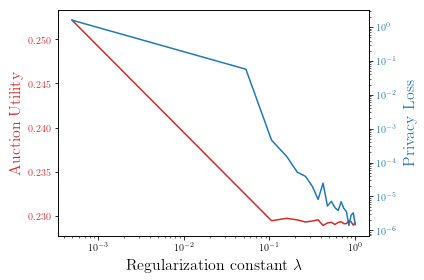

In [28]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(r'Regularization constant $\lambda$', fontsize=16)
ax1.set_xscale('log')
ax1.set_ylabel('Auction Utility', color=color, fontsize=16)
ax1.plot(lambrange, utility, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Privacy Loss', color=color, fontsize=16)  # we already handled the x-label with ax1
ax2.plot(lambrange, privacy_losses, color=color)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()